In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
#import src.transforms as T
import pytorch_lightning as pl
import torch
import numpy as np
import wandb
import torchmetrics
import warnings
import copy
import torchvision 
import pandas as pd
#import seaborn as sns

from skimage.measure import regionprops
from PIL import Image
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision.transforms import functional as F
#from torchvision.models.detection import maskrcnn_resnet50_fpn
#from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader, default_collate
from src.engine import train_one_epoch, evaluate
from src.dataset_module import DEMDataset
from src.model_module import Model
from src.visualizations import viz_bounding_box, vize_sample, viz_mask
from src.utils import move_images, split_train_test_mask, clean_raw_data, analyze_preds, split_dataset_by_percentage, postprocess_iou, postprocess_slope, apply_watermask
from src.config_model import get_config
from src.transforms import clipped_zoom
import sklearn.metrics as skmetrics
from scipy.ndimage import gaussian_filter

/tmp/ipykernel_105/487703548.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available and configured correctly.")
else:
    print("No GPU available or GPU configuration is incorrect.")

GPU is available and configured correctly.


In [3]:
# Get training data
# git lfs pull "data", git lfs pull "data/Sophia/data_clean/data_train/data_original"

# Track all images
# git lfs track "data/**"
# git add . 
# git commit, git push

# shared memory
# df -h /dev/shm
# ls -la /dev/shm

# set working directory
# cd ~

# If random seed is set, losses result in NaN

import random
# Set a fixed seed value
seed_value = 42
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Get model configuration
# Possible models:
# baseline, aspect_slope_baseline, slope_baseline, aspect_baseline
# baseline_box_axis
config_model = "final_model" 
scaled = False

if scaled:
    mean_sd = pd.read_csv('data/Sophia/dataframe/mean_sd_scaled.csv')
else:
    
    mean_sd = pd.read_csv('data/Sophia/dataframe/mean_sd.csv')
#min_max = pd.read_csv('data/Sophia/dataframe/min_max_scaled.csv')
config, device, num_classes, worker_processes,gpu, gpu_device, threshold_mask, pretrained_network, transformed_data, change_min_box_axis = get_config(mean_sd, model = config_model)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/jovyan/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:03<00:00, 58.0MB/s] 


In [6]:
# Some test for model config
if not len(config["channel_list"]) == config["n_channel"]:
    warnings.warn("Desired channels don't correspond to the number of channels")
if num_classes != 2:
    warnings.warn("Model predicts not just RTS")

In [7]:
# Get data
name = "Sophia"
if scaled:
    data_path = f'data/{name}/data_clean/data_train/data_original_scaled'
    data_path_transformed = f'data/{name}/data_clean/data_train/data_original_plus_transformed_scaled'    
else:
    data_path = f'data/{name}/data_clean/data_train/data_original'
    data_path_transformed = f'data/{name}/data_clean/data_train/data_original_plus_transformed'
random.seed(seed_value)
percentage = 0.8

In [8]:
if transformed_data: # Make sure that transformed image is in same group as untransformed image to avoid information leakage
    print('transformed data')
    # Find number of train in original dataset
    img_name_org = [item for item in os.listdir(os.path.join(data_path, "images"))
                               if item.endswith(".tif")]

    n_train = int(len(img_name_org) * percentage)

    # get original train and val name (without .tif) with permutation
    train_name = random.sample(img_name_org, n_train)
    val_name =[item[:-4] for item in img_name_org if item not in train_name]

    # Get transformed data
    dataset_transformed = DEMDataset(data_path_transformed, config["n_channel"], config["channel_list"])
    transformed_name = [item for item in os.listdir(os.path.join(data_path_transformed, "images"))
                               if item.endswith(".tif")]
    
    # Find indices of validaiton data (so that transformed data is in same group as in not transformed)
    matching_indices = []

    for index_A, entry_val in enumerate(val_name):
        for index_transf, entry_transf in enumerate(transformed_name):
            if entry_val in entry_transf:
                matching_indices.append(index_transf)
    # Get indices of training data
    all_ind = list(range(len(transformed_name)))
    unmatched_ind = [num for num in all_ind if num not in matching_indices]         
    
    # split data
    train_set = torch.utils.data.Subset(dataset_transformed, matching_indices)
    val_set = torch.utils.data.Subset(dataset_transformed, unmatched_ind)
    print(len(train_set), len(val_set), len(dataset_transformed))
                   
else:
    dataset = DEMDataset(data_path, config["n_channel"], config["channel_list"])
    #test_set = DEMDataset(test_path, config["n_channel"], config["channel_list"])
    
    # Split the dataset in train and val set
    train_set, val_set = split_dataset_by_percentage(dataset, percentage, seed_value)
    print(len(train_set), len(val_set), len(dataset))

591 148 739


In [9]:
model = Model(
    num_classes, pretrained_network, config, change_min_box_axis)

In [ ]:
train_set[0][0].shape, len(train_set), config["epochs"] , device

In [ ]:
train_set[32][0][0].numpy().min()

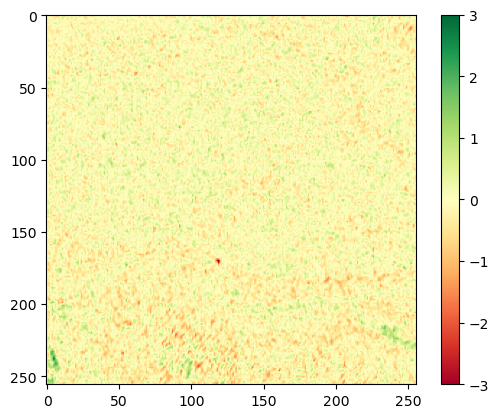

In [13]:
from matplotlib.colors import TwoSlopeNorm
center_scaled = 0
viz_max = 3
viz_min = -3
img = train_set[32][0][0].numpy()
norm = TwoSlopeNorm(vmin=viz_min, vcenter=center_scaled, vmax=viz_max)
if scaled:
    plt.imshow(img ,cmap='RdYlGn')
    plt.colorbar()
else:
    plt.imshow(img ,cmap='RdYlGn', norm=norm)
    plt.colorbar()

In [14]:
# Define training and validation data loaders: Custome collate_fn makes list of batches. 
# batch consists of:
    # a list (size = batch size) of image [c,h,w]
    # list (size = batch size) of dictionaries (= annotations including mask) where mask has size [c,h,w]
# This format is needed because library from torchvision expects a list of images/ targets. Default collate batches images to one single image size [b,c,h,w] and annotations to one single dictionary where matrixes such as mask have size [b,c,h,w]
train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=config['batch_size'], shuffle=True, num_workers=worker_processes,
    collate_fn=lambda x: list(zip(*x))) # transforms from [(input_1, label_1), (input_2, label_2), ...] to [(input_1, input_2, ...)], [label_1, label_2, ...)]

val_dataloader = torch.utils.data.DataLoader(
    val_set, batch_size=config['batch_size'], shuffle=False, num_workers=worker_processes,
    collate_fn=lambda x: list(zip(*x)))

***
## Train model

In [15]:
wandb.finish()

In [16]:
# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='thesis_report', name = "final_model_transformed")

# add your batch size to the wandb config
wandb_logger.experiment.config["batch_size"] = config['batch_size']

wandb: Currently logged in as: sophia-ly-16 (rts). Use `wandb login --relogin` to force relogin


In [17]:
# Track learning rate and model checkpoints 

lr_monitor = LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoint',
    filename='maskrcnn_{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,  # Save the top 3 checkpoints
    verbose=True, # Whether callback will print information when a checkpoint is saved 
    monitor="sum_loss_validation",  # validation loss: 'val_loss', validation accuracy: "val_accuracy"
    mode='min',  # 'min' for val_loss, max for val_accuracy
    every_n_epochs=1,  # Save a checkpoint every x epochs
    every_n_train_steps=None,  # Save a checkpoint every N training steps (set to None to disable)
    train_time_interval=None  # Save a checkpoint after a certain time interval (set to None to disable)
)

# early stopping monitors a specified metric (e.g., validation loss) 
# Training is stopped if the metric does not improve for a certain number of epochs
early_stop_callback = EarlyStopping(
   monitor='sum_loss_validation',
   min_delta=0.00, # Minimum change in the monitored quantity to qualify as an improvement
   patience=5, # Number of epochs with no improvement after which training will be stopped
   verbose=1, # Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
   mode='min'
)

callbacks_trainer =[lr_monitor, checkpoint_callback] # , early_stop_callback]

In [18]:
if gpu:
    # Training with GPU Accelerator using 2 GPUs
    trainer = pl.Trainer(devices=gpu_device, accelerator="gpu", max_epochs=config["epochs"], deterministic=False,callbacks=callbacks_trainer,logger=wandb_logger )
else:
# CPU accelerator
    trainer = pl.Trainer(accelerator="cpu", max_epochs=config["epochs"], deterministic=True,callbacks=callbacks_trainer,logger=wandb_logger )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)

In [ ]:
wandb.finish()

In [ ]:
if config['drop_out_apply']:
    model.eval()
    model.detector.roi_heads.box_head.fc7.weight = model.detector.roi_heads.box_head.fc7[0].weight
    model.detector.roi_heads.box_head.fc7.bias = model.detector.roi_heads.box_head.fc7[0].bias

In [21]:
file_path = 'final_model_transformed.pth'
# Save the model
torch.save(model.state_dict(), file_path)

***

In [11]:
from shapely.geometry import shape

In [12]:
import rasterio
from rasterio.features import shapes
import fiona
from shapely.geometry import Polygon, mapping

In [358]:
# Create an iterator from the DataLoader
data_iter = iter(test_dataloader)

n_batch = 7
data_iter = iter(test_dataloader)
for i in range(n_batch):
    print("batch", i)
    batch_test = next(data_iter)

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6


In [359]:
img_org, targ_org = batch_test
preds = model.forward(img_org)
preds_org = model.forward(img_org)

In [361]:
targ_org[img_index]

{'boxes': tensor([[ 27., 177.,  33., 186.]]),
 'labels': tensor([1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': 34,
 'area': tensor([54.]),
 'iscrowd': tensor([0]),
 'tile': '2010-2016_tile_16_41_7_3_2_7.tif',
 'num objs': 1,
 'geo_meta': {'driver': 'GTiff',
  'count': 1,
  'height': 256,
  'width': 256,
  'crs': CRS.from_epsg(3413),
  'transform': Affine(6.0, 0.0, -2438457.0,
         0.0, -6.0, 21737.0),
  'dtype': 'int64'}}

Number of predicted RTS: 1 Number of labeled RTS: 1
accuracy: 0.9990997314453125 precision: 0.7808219178082192 recall: 0.8085106382978723 f1: 0.7944250871080138 IoU: 0.6589595375722543


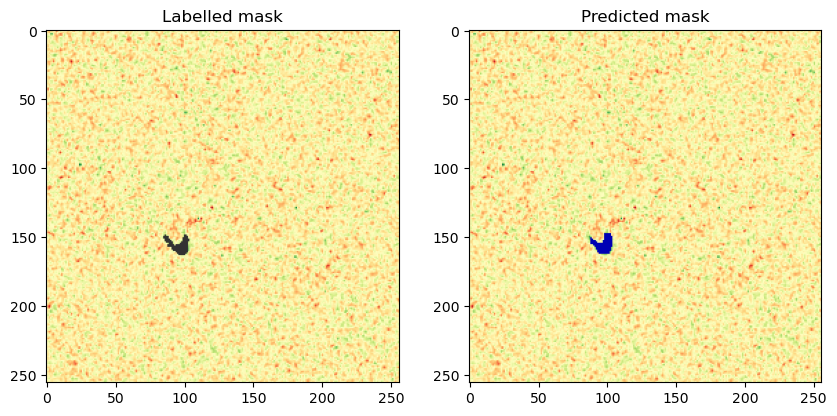

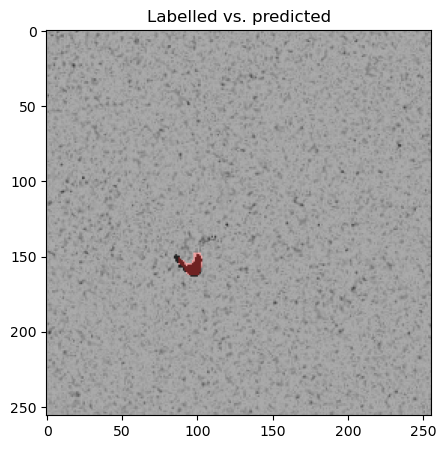

In [363]:
img_index = 2
viz_mask(img_org, targ_org, preds_org, img_index, viz_max = 3, viz_min = -3)

In [348]:
RTS_id = 0
my_schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'}
}

if create_shp == True:
    n_instance_pred = preds[img_i]['masks'].shape[0]
    for instance in range(n_instance_pred):
        instance_mask = preds[img_i]['masks'][instance].detach().numpy()
        instance_mask = (instance_mask >= 0.5).astype(int)
        dir_name = os.getcwd() + '/prediction' + f'/aaaprediction_{img_i}_{instance}.tif'
        meta = targ_org[img_index]['geo_meta']
        # Write prediction to tif
        with rasterio.open(dir_name, 'w', **meta) as dst:
                        dst.write(instance_mask)

        # Read tif info to convert to shp
        with rasterio.open(dir_name, 'r') as src:
            data = src.read(1)
            data = data.astype('int16')
            # Get the shapes of the features in the raster
            results = [{'geometry': s} for s in rasterio.features.shapes(data, mask=None, transform=src.transform)] # results in list of [RTS, img bbox]
            
        getdata = 0
        result_dict = results[getdata]

        # Create a Shapely geometry object
        geometry_info = result_dict['geometry']
        shapely_geometry = Polygon(geometry_info[0]['coordinates'][0])  # Access inner list

        # Create a dictionary compatible with Fiona write
        feature = {
            'geometry': mapping(shapely_geometry),
            'properties': {'id': RTS_id}  # You may need to adjust this based on your data
        }
        RTS_id+=1
        
        modelpath = os.getcwd()+ '/prediction' + "/model_result.shp"
        if os.path.exists(modelpath):
            # Create sh
            with fiona.open(modelpath, mode='a', driver='ESRI Shapefile', schema=my_schema, crs=src.crs) as output:
                output.write(feature)
        else:
            # append RTS
            with fiona.open(modelpath, mode='w', driver='ESRI Shapefile', schema=my_schema, crs=src.crs) as output:
                output.write(feature)

In [16]:
def extract_shp(prediction, target, img_i, root_path, RTS_id, batch_i):
    n_instance_pred = prediction[img_i]['masks'].shape[0]
    for instance in range(n_instance_pred):
        instance_mask = prediction[img_i]['masks'][instance].detach().numpy()
        instance_mask = (instance_mask >= 0.5).astype(int)
        dir_name =  root_path + '/prediction' + f'/prediction_{batch_i}_{img_i}_{instance}.tif'
        meta = target[img_index]['geo_meta']
        # Write prediction to tif
        with rasterio.open(dir_name, 'w', **meta) as dst:
                        dst.write(instance_mask)

        # Read tif info to convert to shp
        with rasterio.open(dir_name, 'r') as src:
            data = src.read(1)
            data = data.astype('int16')
            # Get the shapes of the features in the raster
            results = [{'geometry': s} for s in rasterio.features.shapes(data, mask=None, transform=src.transform)] # results in list of [RTS, img bbox]

        getdata = 0
        result_dict = results[getdata]

        # Create a Shapely geometry object
        geometry_info = result_dict['geometry']
        shapely_geometry = Polygon(geometry_info[0]['coordinates'][0])  # Access inner list

        # Create a dictionary compatible with Fiona write
        feature = {
            'geometry': mapping(shapely_geometry),
            'properties': {'id': RTS_id}  # You may need to adjust this based on your data
        }
        RTS_id+=1

        modelpath = root_path + '/prediction' + "/model_result.shp"
        if os.path.exists(modelpath):
            # Create sh
            with fiona.open(modelpath, mode='a', driver='ESRI Shapefile', schema=my_schema, crs=src.crs) as output:
                output.write(feature)
        else:
            # append RTS
            with fiona.open(modelpath, mode='w', driver='ESRI Shapefile', schema=my_schema, crs=src.crs) as output:
                output.write(feature)
    return RTS_id
        

***
### Apply model to test data

In [105]:
# Get model configuration
# Possible models:
# baseline, 3c_baseline, 2c_slope_baseline, 2c_aspect_baseline
# baseline_box_axis
config_model = "final_model" 
postprocess_iou_apply = False # only keeps RTS detections if iou between mask and boundary box is > iou_min 
postprocess_slope_apply = False # only keeps RTS detections that are not in high slopes (wher ehigh slope degree_thresh >= 25, if x fraction is on slope: iou threshold_onslope = 0.8)
site_name = 'peel' # 'tukto'
postprocess_watermask_apply = False

name ='Sophia'
#-----------------------------------------------------------------------------
test_path = f'data/{name}/data_clean/2010_2021'
slope_path = test_path+'/slope'
get_RTS_info = True # Calculate RTS metric: mean_intensity_, sd_intensity_, pix_size_, circularity_, solidity_, max_diameter_ 
config, device, num_classes, worker_processes,gpu, gpu_device, threshold_mask, pretrained_network, transformed_data, change_min_box_axis = get_config(mean_sd, model = config_model)

In [106]:
scaled = False
if scaled:
    min_max = pd.read_csv('data/Sophia/dataframe/min_max_scaled.csv')
else:
    min_max=0

In [107]:
# Load the pretrained weights from the .pth file.
model = Model(
    num_classes, pretrained_network, config, change_min_box_axis)

model_path = "model/final_model_patience3.pth"
checkpoint = torch.load(model_path)
'''
if config['drop_out_apply']:
    del checkpoint['detector.roi_heads.box_head.fc7.0.weight']
    del checkpoint['detector.roi_heads.box_head.fc7.0.bias']'''
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [108]:
model = model.to("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [109]:
test_set = DEMDataset(test_path, config["n_channel"], config["channel_list"])
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=config['batch_size'], shuffle=False, num_workers=0,
    collate_fn=lambda x: list(zip(*x)))

***

In [110]:
# thresholds that decide TP, TN
iou_thresholds = [0.5]

# Config for shp creation 
create_shp = False # True, False
RTS_ind = 0 # RTS_id to keep track of number of predicted RTS
my_schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'}
}


# Set model to evaluation mode
model.eval()

# Performance metric
# RTS detection level
accuracy_ = []
precision_ = []
recall_ = []
F1_ = []
# loss
classificationloss_ = []
box_regressionloss_ = []
maskloss_ = []
iouRTS_ = []
# mask of detected RTS level
accuracy_pixel_ = []
precision_pixel_ = []
recall_pixel_ = []
F1_pixel_ = []
IoU_pixel_ = []
# RTS metric
accuracy_img_ = []
precision_img_ = []
recall_img_ = []
F1_img_ = []
IoU_img_ = []

# feature
mean_intensity = []
sd_intensity = []
pix_size = []
circularity = []
solidity = []
max_diameter = []
area = []
RTS_TP_id = []


with torch.no_grad():
    # iterate over batches
    for i, batch in enumerate(test_dataloader):
        print("Batch; ", i)
        img_org, targ_org = batch
        preds = model.forward(img_org)

        # Postprocess--------------------------------------------------
        if postprocess_iou_apply or postprocess_slope_apply:
            for img_i in range(len(preds)):
                if postprocess_iou_apply:
                    preds[img_i]["boxes"], preds[img_i]["labels"], preds[img_i]["scores"], preds[img_i]["masks"] = postprocess_iou(preds[img_i],  threshold_mask=0.5, iou_min = 0.25)
                if postprocess_slope_apply:
                    slope_tile = os.path.join(slope_path, targ_org[img_i]['tile'])
                    slope_img = gaussian_filter(np.array(Image.open(slope_tile)), sigma=15)
                    if np.mean(slope_img)> 60 and np.median(slope_img)>60:
                        preds[img_i]["boxes"], preds[img_i]["labels"], preds[img_i]["scores"], preds[img_i]["masks"] = postprocess_slope(preds[img_i], slope_img, min_max, degree_thresh = 30, threshold_mask=0.5, threshold_onslope = 0.8)
                if postprocess_watermask_apply:
                    preds[img_i]["boxes"], preds[img_i]["labels"], preds[img_i]["scores"], preds[img_i]["masks"] = apply_watermask(targ_org[img_i], preds[img_i], site_name, test_path)
        # Get shapefile
        if create_shp:
            for img_i in range(len(preds)):
                    RTS_ind = extract_shp(preds, targ_org, img_i, os.getcwd(), RTS_ind, i)

        # calculate performance metric-------------------------------
        if  get_RTS_info:
            batch_accuracy, batch_precision, batch_recall, batch_F1, classification_loss, box_regression_loss, mask_loss, iou_RTS, RTS_TP,accuracy_pixel, precision_pixel, recall_pixel, F1_pixel, IoU_pixel, accuracy_img, precision_img, recall_img, F1_img, IoU_img = model.test_step(img_org, targ_org, preds, iou_thresholds= iou_thresholds, get_TP_ind= get_RTS_info) 
            RTS_TP_id+= RTS_TP
        else:
            batch_accuracy, batch_precision, batch_recall, batch_F1, classification_loss, box_regression_loss, mask_loss, iou_RTS,accuracy_pixel, precision_pixel, recall_pixel, F1_pixel, IoU_pixel, accuracy_img, precision_img, recall_img, F1_img, IoU_img = model.test_step(img_org, targ_org, preds, iou_thresholds= iou_thresholds)

        # Collect the metrics for this batch
        # on RTS level
        accuracy_.append(batch_accuracy)
        precision_.append(batch_precision)
        recall_.append(batch_recall)
        F1_.append(batch_F1)
        # Loss
        classificationloss_.append(classification_loss)
        box_regressionloss_.append(box_regression_loss)
        maskloss_.append(mask_loss)
        iouRTS_.append(iou_RTS)
        # On mask per detected RTS level
        accuracy_pixel_.append(accuracy_pixel)
        precision_pixel_.append(precision_pixel)
        recall_pixel_.append(recall_pixel)
        F1_pixel_.append(F1_pixel)
        IoU_pixel_.append(IoU_pixel)

        # on binary image level
        accuracy_img_.append(accuracy_img)
        precision_img_.append(precision_img)
        recall_img_.append(recall_img)
        F1_img_.append(F1_img)
        IoU_img_.append(IoU_img)

        # Calculate RTS metric: mean_intensity_, sd_intensity_, pix_size_, circularity_, solidity_, max_diameter_ 
        if get_RTS_info:
            # iterate through tile/ batch
            for tile_id in range(len(preds)):
                mean_intensity_, sd_intensity_, pix_size_, circularity_, solidity_, max_diameter_, area_ = analyze_preds(preds, img_org, tile_id=tile_id, threshold_mask = 0.5)
                # Collect the metrics for this batch
                mean_intensity = mean_intensity + mean_intensity_
                sd_intensity = sd_intensity + sd_intensity_
                pix_size = pix_size + pix_size_
                circularity = circularity + circularity_
                solidity = solidity + solidity_
                max_diameter = max_diameter + max_diameter_
                area = area + area_
            
    print("Finished")
        

Batch;  0
Batch;  1
Batch;  2
Batch;  3
Batch;  4
Batch;  5
Batch;  6
Batch;  7
Batch;  8
Batch;  9
Batch;  10
Batch;  11
Batch;  12
Batch;  13
Batch;  14
Batch;  15
Batch;  16
Batch;  17
Batch;  18
Batch;  19
Batch;  20
Batch;  21
Batch;  22
Batch;  23
Batch;  24
Batch;  25
Batch;  26
Batch;  27
Batch;  28
Batch;  29
Batch;  30
Batch;  31
Batch;  32
Batch;  33
Batch;  34
Batch;  35
Batch;  36
Batch;  37
Batch;  38
Batch;  39
Batch;  40


/home/jovyan/work/master-thesis/src/model_module.py:604: RuntimeWarning: Mean of empty slice
  accuracy_pixel = np.nanmean(accuracy_pixel_)
/home/jovyan/work/master-thesis/src/model_module.py:605: RuntimeWarning: Mean of empty slice
  precision_pixel = np.nanmean(precision_pixel_)
/home/jovyan/work/master-thesis/src/model_module.py:606: RuntimeWarning: Mean of empty slice
  recall_pixel = np.nanmean(recall_pixel_)
/home/jovyan/work/master-thesis/src/model_module.py:607: RuntimeWarning: Mean of empty slice
  F1_pixel = np.nanmean(F1_pixel_)
/home/jovyan/work/master-thesis/src/model_module.py:608: RuntimeWarning: Mean of empty slice
  IoU_pixel = np.nanmean(iou_pixel_)


Batch;  41
Batch;  42
Batch;  43
Batch;  44
Batch;  45
Batch;  46
Batch;  47
Batch;  48
Batch;  49
Batch;  50
Batch;  51
Batch;  52
Batch;  53
Batch;  54
Batch;  55
Batch;  56
Batch;  57
Batch;  58
Batch;  59
Batch;  60
Batch;  61
Batch;  62
Batch;  63
Batch;  64
Batch;  65
Batch;  66
Batch;  67
Batch;  68
Batch;  69
Batch;  70
Batch;  71
Batch;  72
Batch;  73
Batch;  74
Batch;  75
Batch;  76
Batch;  77
Batch;  78
Batch;  79
Batch;  80
Batch;  81
Batch;  82
Batch;  83
Batch;  84
Batch;  85
Batch;  86
Batch;  87
Batch;  88
Batch;  89
Batch;  90
Batch;  91
Batch;  92
Batch;  93
Batch;  94
Batch;  95
Batch;  96
Batch;  97
Batch;  98
Batch;  99
Batch;  100
Batch;  101


KeyboardInterrupt: 

In [76]:
# on RTS detetion level
F1 = np.nanmean(F1_)
recall = np.nanmean(recall_)
precision = np.nanmean(precision_)
accuracy = np.nanmean(accuracy_)
iou = np.nanmean(iouRTS_)
# Loss
classificationloss = torch.nanmean(torch.stack(classificationloss_)) 
box_regressionloss = torch.nanmean(torch.stack(box_regressionloss_))
maskloss = torch.nanmean(torch.stack(maskloss_))
# on mask of detected RTS level
F1_pixel = np.nanmean(F1_pixel_)
recall_pixel = np.nanmean(recall_pixel_)
precision_pixel = np.nanmean(precision_pixel_)
accuracy_pixel = np.nanmean(accuracy_pixel_)
iou_pixel = np.nanmean(IoU_pixel_)
# on binary image level
F1_img = np.nanmean(F1_img_)
recall_img = np.nanmean(recall_img_)
precision_img = np.nanmean(precision_img_)
accuracy_img = np.nanmean(accuracy_img_)
iou_img = np.nanmean(IoU_img_)

In [77]:
RTS_metric = pd.DataFrame([{'RTS_F1': F1, 'RTS_recall': recall, 'RTS_precision': precision, 'RTS_accuracy': accuracy, 'bbox_iou': iou, 'classificationloss': classificationloss.item(), 'box_regressionloss': box_regressionloss.item(), 'maskloss':maskloss.item()}])
#df_metric.to_csv(f'{config_model}_performance.csv', index=False)
np.round(RTS_metric,2)


,RTS_F1,RTS_recall,RTS_precision,RTS_accuracy,bbox_iou,classificationloss,box_regressionloss,maskloss
0,0.76,0.77,0.77,0.65,0.52,1.26,15.22,0.69


In [78]:
image_metric = pd.DataFrame([{'image_F1': F1_img, 'image_recall': recall_img, 'image_precision': precision_img, 'image_accuracy': accuracy_img, 'image_iou': iou_img}])
#df_metric.to_csv(f'{config_model}_performance.csv', index=False)
np.round(image_metric,2)

,image_F1,image_recall,image_precision,image_accuracy,image_iou
0,0.73,0.74,0.74,0.95,0.6


In [79]:
mask_metric = pd.DataFrame([{'Mask_F1': F1_pixel, 'Mask_recall': recall_pixel, 'Mask_precision': precision_pixel, 'Mask_accuracy': accuracy_pixel, 'Mask_iou': iou_pixel}])
#df_metric.to_csv(f'{config_model}_performance.csv', index=False)
np.round(mask_metric,2)

,Mask_F1,Mask_recall,Mask_precision,Mask_accuracy,Mask_iou
0,0.83,0.84,0.85,1.0,0.72


In [80]:
feature = pd.DataFrame({'mean_intensity': mean_intensity, 'sd_intensity': sd_intensity, 'area':area,'pix_size': pix_size, 'max_diameter': max_diameter, 'circularity': circularity, 'solidity': solidity, 'label': RTS_TP_id})
#df_save.to_csv(f'{config_model}_RTS_metric.csv', index=False)
feature

,mean_intensity,sd_intensity,area,pix_size,max_diameter,circularity,solidity,label
0,2.294779,1.040331,89.0,89,19.416488,0.586807,0.967391,1
1,1.010773,0.784367,94.0,94,14.317821,0.822377,0.903846,-1
2,2.279077,1.153378,178.0,178,24.166092,0.564098,0.784141,1
3,2.450697,1.025370,116.0,116,20.591260,0.654930,0.834532,-1
4,1.413655,0.799041,117.0,117,14.317821,0.980274,0.943548,1
...,...,...,...,...,...,...,...,...
388,0.557719,0.566162,116.0,116,15.811388,0.759871,0.892308,-1
389,1.251314,0.871050,289.0,289,26.400758,0.606914,0.809524,1
390,1.646437,1.200378,671.0,671,42.941821,0.382348,0.806490,1
391,1.062605,0.793214,228.0,228,21.095023,0.706133,0.850746,1


In [81]:
# Feature of TP
df_TP = feature[feature["label"]==1]
np.round(df_TP.agg(['mean', 'median']),2)

,mean_intensity,sd_intensity,area,pix_size,max_diameter,circularity,solidity,label
mean,1.56,0.85,398.31,398.31,28.93,0.69,0.86,1.0
median,1.40,0.75,234.00,234.00,24.17,0.71,0.88,1.0


In [82]:
# Features of FP
df_FP = feature[feature["label"]==-1]
np.round(df_FP.agg(['mean', 'median']),2)

,mean_intensity,sd_intensity,area,pix_size,max_diameter,circularity,solidity,label
mean,1.13,0.72,215.14,215.14,22.29,0.69,0.84,-1.0
median,0.98,0.62,124.50,124.50,18.83,0.70,0.87,-1.0


In [54]:
df_TP.columns

Index(['mean_intensity', 'sd_intensity', 'area', 'pix_size', 'max_diameter',
       'circularity', 'solidity', 'label'],
      dtype='object')

(array([ 1.,  0.,  0.,  2.,  1.,  4.,  6., 14., 17.,  9.]),
 array([0.46748682, 0.52073814, 0.57398946, 0.62724077, 0.68049209,
        0.73374341, 0.78699473, 0.84024605, 0.89349736, 0.94674868,
        1.        ]),
 <BarContainer object of 10 artists>)

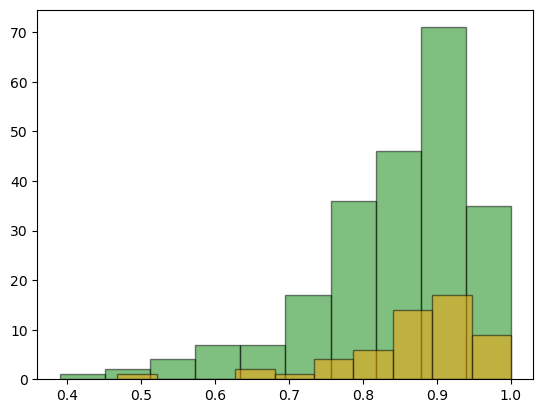

In [55]:
x = 'solidity'
plt.hist(df_TP[x], color='green', alpha=0.5, edgecolor='black')
plt.hist(df_FP[x], color='orange', alpha=0.5, edgecolor='black')

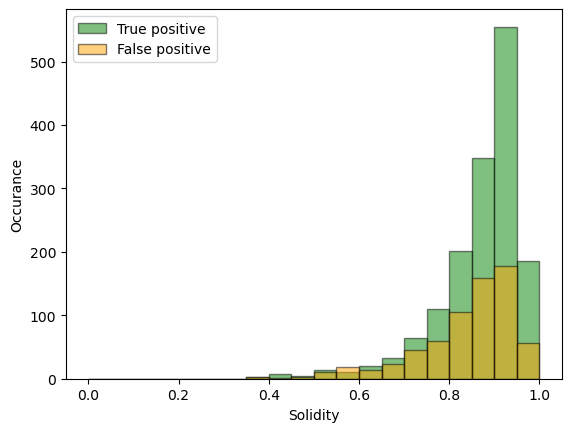

In [92]:
# Visualization of x feauture
x = 'solidity'
x_title = 'Solidity'
binwidth = 0.05

fig, ax1 = plt.subplots()
x_min = min(int(np.floor(min(df_FP[x]))), int(np.floor(min(df_TP[x]))))
x_max = max(int(np.floor(max(df_FP[x]))), int(np.floor(max(df_TP[x]))))
plt.hist(df_TP[x], color='green', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth), edgecolor='black')
plt.hist(df_FP[x], color='orange', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth),edgecolor='black')
ax1.set_xlabel(x_title)
ax1.set_ylabel('Occurance')
legend = ax1.get_legend()
ax1.legend(['True positive', 'False positive'])
#plt.xlim(0, )
#plt.title(f'{config_model}')
plt.savefig(f'{config_model}_{x}_21.png')
plt.show()


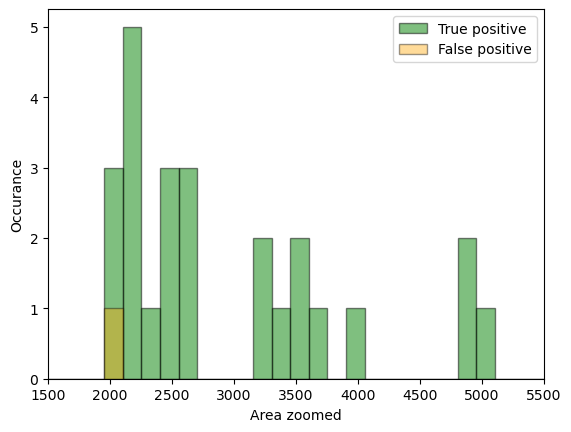

In [109]:
# Visualization of x feauture TP predicted vs labelled
x = 'area'
x_title = 'Area zoomed'
binwidth = 150

fig, ax1 = plt.subplots()
x_min = min(int(np.floor(min(img_feature[x]))), int(np.floor(min(df_TP[x]))))
x_max = max(int(np.floor(max(img_feature[x]))), int(np.floor(max(df_TP[x]))))

plt.hist(df_TP[df_TP[x]>2000][x], color='green', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth),edgecolor='black')
plt.hist(df_FP[df_FP[x]>2000][x], color='orange', alpha=0.4, bins= np.arange(x_min, x_max+ binwidth, binwidth), edgecolor='black')
ax1.set_xlabel(x_title)
ax1.set_ylabel('Occurance')
legend = ax1.get_legend()
ax1.legend(['True positive', 'False positive'])
plt.xlim(1500, 5500)
#plt.title(f'{config_model}')
plt.savefig(f'{config_model}_{x}_21tot_zoomed.png')
plt.show()


***
### Calculate features of test image

In [63]:
test_path

'data/Sophia/data_clean/2010_2021'

In [81]:
mean_intensity_ = []
sd_intensity_  = []
pix_size_ = []
circularity_ = []
solidity_ = []
max_diameter_ = []
area_ = []

tile_names = os.listdir(test_path + '/masks')
for tile in tile_names:
    if tile.endswith('.tif'):
        imge_mask = np.array(Image.open(test_path + f'/masks/{tile}'))
        image_height = np.array(Image.open(test_path + f'/images/{tile}'))

        n_instances = len(np.unique(imge_mask))-1
        for i in range(1, n_instances+1):
            instance_val = np.unique(imge_mask)[i]
            # Make mask binary
            mask_boolean = (imge_mask == instance_val).astype(int)
            # Calculate values from intensity image
            mean_intensity = np.nanmean(image_height[mask_boolean>0])
            sd_intensity = np.std(image_height[mask_boolean>0])
            # Calculate values based on shape

            mask_prop = regionprops(mask_boolean)[0] # We only have one instance per binary mask
            pix_size = np.count_nonzero(mask_boolean)
            RTS_perimeter = mask_prop.perimeter
            if RTS_perimeter ==0: # regionprop cannot handle very small objects->approximate perimeter
                RTS_perimeter = mask_prop.feret_diameter_max *2
            circularity = (4*np.pi*pix_size)/(RTS_perimeter**2)
            solidity = mask_prop.solidity
            max_diameter = mask_prop.feret_diameter_max
            area = mask_prop.area
            # Append values
            mean_intensity_.append(mean_intensity)
            sd_intensity_.append(sd_intensity)
            pix_size_.append(pix_size)
            circularity_.append(circularity)
            solidity_.append(solidity)
            max_diameter_.append(max_diameter)
            area_.append(area)

In [83]:
img_feature = pd.DataFrame({'mean_intensity': mean_intensity_, 'sd_intensity': sd_intensity_, 'area': area_, 'pix_size': pix_size_,  'max_diameter': max_diameter_,'circularity': circularity_, 'solidity': solidity_})
#df_save.to_csv(f'{config_model}_RTS_metric.csv', index=False)
np.round(img_feature.agg(['mean', 'median']),2)

,mean_intensity,sd_intensity,area,pix_size,max_diameter,circularity,solidity
mean,1.41,0.67,308.25,308.25,25.45,0.65,0.83
median,1.20,0.58,163.00,163.00,20.62,0.64,0.85


In [84]:
img_feature.columns

Index(['mean_intensity', 'sd_intensity', 'area', 'pix_size', 'max_diameter',
       'circularity', 'solidity'],
      dtype='object')

(array([  9.,   5.,  17.,  17.,  29.,  75., 161., 291., 643., 307.]),
 array([0.37321272, 0.43589145, 0.49857018, 0.56124891, 0.62392763,
        0.68660636, 0.74928509, 0.81196382, 0.87464254, 0.93732127,
        1.        ]),
 <BarContainer object of 10 artists>)

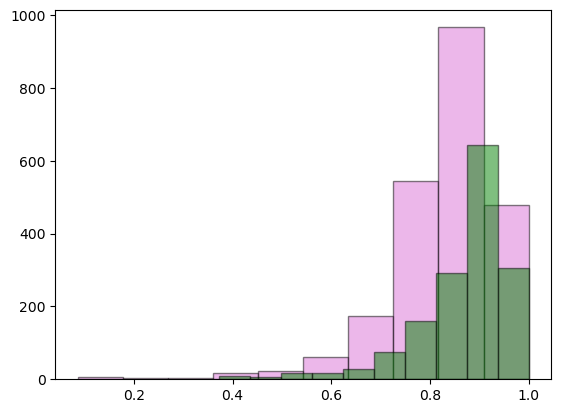

In [110]:
x = 'solidity'
plt.hist(img_feature[x], color='orchid', alpha=0.5, edgecolor='black')
plt.hist(df_TP[x], color='green', alpha=0.5, edgecolor='black')

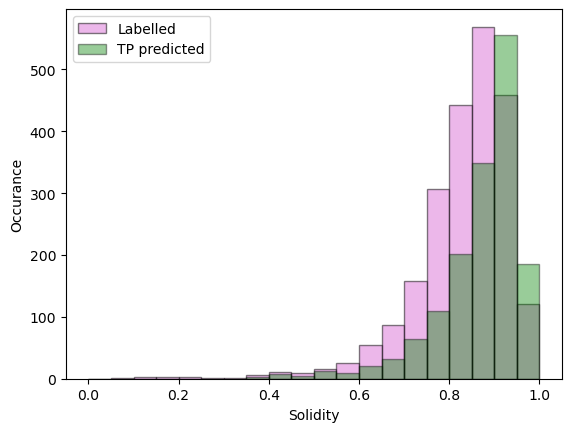

In [112]:
# Visualization of x feauture TP predicted vs labelled
x = 'solidity'
x_title = 'Solidity'
binwidth = 0.05

fig, ax1 = plt.subplots()
x_min = min(int(np.floor(min(img_feature[x]))), int(np.floor(min(df_TP[x]))))
x_max = max(int(np.floor(max(img_feature[x]))), int(np.floor(max(df_TP[x]))))
plt.hist(img_feature[x], color='orchid', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth),edgecolor='black')
plt.hist(df_TP[x], color='green', alpha=0.4, bins= np.arange(x_min, x_max+ binwidth, binwidth), edgecolor='black')
ax1.set_xlabel(x_title)
ax1.set_ylabel('Occurance')
legend = ax1.get_legend()
ax1.legend(['Labelled', 'TP predicted'])
#plt.xlim(0.2, 1)
#plt.title(f'{config_model}')
plt.savefig(f'{config_model}_{x}_labelled_21tot.png')
plt.show()


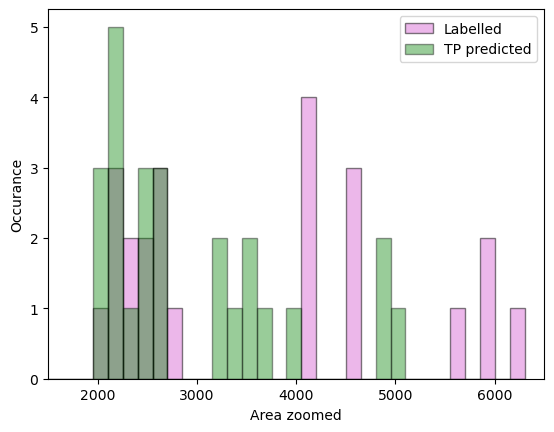

In [105]:
# Visualization of x feauture TP predicted vs labelled
x = 'area'
x_title = 'Area zoomed'
binwidth = 150

fig, ax1 = plt.subplots()
x_min = min(int(np.floor(min(img_feature[x]))), int(np.floor(min(df_TP[x]))))
x_max = max(int(np.floor(max(img_feature[x]))), int(np.floor(max(df_TP[x]))))
plt.hist(img_feature[img_feature[x]>2000][x], color='orchid', alpha=0.5, bins= np.arange(x_min, x_max + binwidth, binwidth),edgecolor='black')
plt.hist(df_TP[df_TP[x]>2000][x], color='green', alpha=0.4, bins= np.arange(x_min, x_max+ binwidth, binwidth), edgecolor='black')
ax1.set_xlabel(x_title)
ax1.set_ylabel('Occurance')
legend = ax1.get_legend()
ax1.legend(['Labelled', 'TP predicted'])
plt.xlim(1500, 6500)
#plt.title(f'{config_model}')
plt.savefig(f'{config_model}_{x}_labelled_21tot_zoomed.png')
plt.show()


***
### Save result

In [ ]:
df_metric = pd.DataFrame([{'F1': F1, 'recall': recall, 'precision': precision, 'accuracy': accuracy, 'iou': iou, 'classificationloss': classificationloss.item(), 'box_regressionloss': box_regressionloss.item(), 'maskloss':maskloss.item()}])
df_metric.to_csv(f'{config_model}_performance.csv', index=False)
df_metric

In [ ]:
df_save = pd.DataFrame({'mean_intensity': mean_intensity, 'sd_intensity': sd_intensity, 'pix_size': pix_size, 'circularity': circularity, 'solidity': solidity, 'max_diameter': max_diameter, 'label': RTS_TP_id})
df_save.to_csv(f'{config_model}_RTS_metric.csv', index=False)
df_save.head()

In [299]:
df_FP = df_save[df_save["label"]==-1]
df_FP.agg(['mean', 'median'])

(1, 142)

In [ ]:
df_TP = df_save[df_save["label"]==1]
df_TP.agg(['mean', 'median'])

In [ ]:
# mean_intensity, sd_intensity, pix_size, circularity, solidity, max_diameter
x = max_diameter
df_viz = pd.DataFrame({'x': x, 'label': RTS_TP_id})

fig, ax1 = plt.subplots()
sp1 = sns.histplot(df_viz, x="x", hue="label", element="step", palette={1: 'green', -1: 'orange'}, kde=True)
ax1.set_xlabel(r'Pixel size')
ax1.set_ylabel(r'Max. diameter')
legend = ax1.get_legend()
handles = legend.legend_handles 
legend.remove()
ax1.legend(handles, ['False positive', 'True positive'])
plt.title(f'{config_model}')
plt.show()
plt.savefig(f'{config_model}max_diameter.png')

***
Debug

In [16]:
# Load the pretrained weights from the .pth file.
model = Model(
    num_classes, pretrained_network, config, change_min_box_axis)

model_path = "model/final_model_patience3.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [17]:
test_path = f'data/Sophia/data_clean/2021_also_in_2016_train'


test_set = DEMDataset(test_path, config["n_channel"], config["channel_list"])

In [18]:
from src.transforms import get_transform

In [19]:
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=config['batch_size'], shuffle=False, num_workers=0,
    collate_fn=lambda x: list(zip(*x)))

In [20]:
test_set[0][0].shape

torch.Size([2, 256, 256])

In [21]:
data_iter = iter(test_dataloader)
n_batch =3
for i in range(n_batch):
    print("batch", i)
    batch_test = next(data_iter)
    img_org, targ_org = batch_test

batch 0
batch 1
batch 2


In [22]:
preds = model.forward(img_org)

In [37]:
img_i = 2
preds[img_i]['labels']

tensor([1, 1, 1])

In [38]:
site_name = 'peel' # 'tukto'
transf_box, prediciton, transf_scores, transf_mask = apply_watermask(targ_org[img_i], preds[img_i], site_name, test_path)
len(transf_box)

3

In [146]:
transf_box

tensor([[249.3393, 129.3898, 255.6895, 141.5606]], grad_fn=<IndexBackward0>)

In [144]:
def apply_watermask(target, prediciton, site_name, threshold_outside_water = 0.5):
                    
    # Read tilename
    image_name =target['tile']
    name_part = image_name.split('_')
    tile_name = ('_').join(name_part[1:6])

    # create watermask file name
    original_tile = tile_name.split('_')

    water_name, water_name_below,water_name_above,water_name_left,water_name_right, water_name_above_left, water_name_above_right, water_name_below_left, water_name_below_right = create_watername(original_tile)

    # Check if image is on multiple tiles, read all itles which are intersecting the image
    image_part = image_name.split('_')
    img_y = image_part[-2]
    img_x = image_part[-1][:-4]
    image_part

    # Read water tiles and neighbour water tiles
    if site_name == 'peel':
        water_dir = 'data/Sophia/data_clean/watermask_Peel_merged'
    elif site_name == 'tukto':
        water_dir = 'data/Sophia/data_clean/watermask_tuktoyaktuk_merged'
    else:
        print('Sitename is invalid')

    water_merge = [] # to store all tiles to be merged
    water_file = os.path.join(water_dir, water_name)
    water_tile = rasterio.open(water_file)
    water_merge.append(water_tile)

    # img is on two tiles at the bottom:
    if  int(img_y) ==0: # below
        water_file_below = os.path.join(water_dir, water_name_below)
        water_tile_below = rasterio.open(water_file_below)
        water_merge.append(water_tile_below)
        #print('below')
        if int(img_x) == 8: # belowright
            water_file_below_right = os.path.join(water_dir, water_name_below_right)
            water_tile_below_right = rasterio.open(water_file_below_right)
            water_merge.append(water_tile_below_right)
            #print('below')
        elif int(img_x) == 0: #belowleft
            water_file_below_left = os.path.join(water_dir, water_name_below_left)
            water_tile_below_left = rasterio.open(water_file_below_left)
            water_merge.append(water_tile_below_left) 
            #print('below')

    if int(img_y) == 8: # above
        water_file_above = os.path.join(water_dir, water_name_above)
        water_tile_above = rasterio.open(water_file_above)
        water_merge.append(water_tile_above)
        #print('above')
        if int(img_x) == 8: # aboveright
            water_file_above_right = os.path.join(water_dir, water_name_above_right)
            water_tile_above_right = rasterio.open(water_file_above_right)
            water_merge.append(water_tile_above_right)
            #print('above')
        elif int(img_x)==0: #above left
            water_file_above_left = os.path.join(water_dir, water_name_above_left)
            water_tile_above_left = rasterio.open(water_file_above_left)
            water_merge.append(water_tile_above_left)
            #print('above')

    if int(img_x)== 8: # right
        water_file_right = os.path.join(water_dir, water_name_right)
        water_tile_right = rasterio.open(water_file_right)
        water_merge.append(water_tile_right)    
        #print('right')

    if int(img_x) == 0: #left
        water_file_left = os.path.join(water_dir, water_name_left)
        water_tile_left = rasterio.open(water_file_left)
        water_merge.append(water_tile_left)
        #print('right')

    # merge neighbour water tiles
    merged_water, merged_transf = merge(water_merge)
    # Make water tiles binary
    merged_water = merged_water[0]
    merged_water[merged_water>0]= 2
    merged_water[merged_water<= -9999]= 2 # For undefined values
    merged_water[merged_water <= 0] = 1
    # Create a cropping mask with the boundary of input image
    image_file = os.path.join(test_path, 'images',image_name)
    image_tile = rasterio.open(image_file)
    mask_geometry = [shapely.geometry.box(*image_tile.bounds)]
    mask_array = geometry_mask(mask_geometry, out_shape=merged_water.shape, transform = merged_transf, invert=True)   
    croped_water = merged_water*mask_array
    # Find the top-left, top-right, bottom-left, and bottom-right of the image corners
    # Find indices where the value is 1
    indices = np.where(croped_water >0)

    top_left = (min(indices[0]), min(indices[1]))
    bottom_right = (max(indices[0]), max(indices[1]))
    extracted_water = croped_water[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
    # resize and make water = 0 rest 1
    water_mask_img = skimage.transform.resize(extracted_water, image_tile.shape, mode='constant', order=1)
    water_mask_img[water_mask_img<1.5]=0
    water_mask_img[water_mask_img>0] = 1
    
    keep_i = []
    for predicted_i in range(len(prediciton['labels'])):
        predicted_RTS = prediciton['masks'][predicted_i][0].detach().numpy() # 0 is for channel
        outside_water = water_mask_img * predicted_RTS
        outside_water_fraction = outside_water.sum() / predicted_RTS.sum()
        if outside_water_fraction < threshold_outside_water:
            keep_i.append(False)
            print('remove')
        else:
            keep_i.append(True)

    if len(keep_i)>0:
        boolean_mask = torch.tensor(keep_i)
        transf_box = prediciton["boxes"][boolean_mask] 
        transf_labels = prediciton["labels"][boolean_mask]
        transf_scores = prediciton["scores"][boolean_mask]
        transf_mask = prediciton["masks"][boolean_mask]
    else:
        transf_box = prediciton["boxes"]
        transf_labels = prediciton["labels"]
        transf_scores = prediciton["scores"]
        transf_mask = prediciton["masks"]
    return transf_box, transf_labels, transf_scores, transf_mask

In [192]:
site_name = 'peel' # 'tukto'

In [98]:
targ_org[img_i]

{'boxes': tensor([[247., 128., 255., 140.]]),
 'labels': tensor([1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': 9,
 'area': tensor([96.]),
 'iscrowd': tensor([0]),
 'tile': '2010-2021_tile_15_41_9_1_1_8.tif',
 'num objs': 1,
 'geo_meta': {'driver': 'GTiff',
  'count': 1,
  'height': 256,
  'width': 256,
  'crs': CRS.from_epsg(3413),
  'transform': Affine(6.0, 0.0, -2519801.0,
         0.0, -6.0, 393.0),
  'dtype': 'int64'}}

In [245]:
image_name

'2010-2021_tile_15_41_8_4_8_0.tif'

In [225]:
water_name_above_left, water_name_above_right, water_name_below_left, water_name_below_right

('watermask_15_41_9_5.tif',
 'watermask_15_41_9_3.tif',
 'watermask_15_41_7_5.tif',
 'watermask_15_41_7_3.tif')

In [226]:
water_name_above_left

'watermask_15_41_9_5.tif'

In [99]:
image_i = 3

# Read tilename
image_name ='2010-2021_tile_15_41_9_1_1_8.tif' #targ_org[image_i]['tile']
name_part = image_name.split('_')
tile_name = ('_').join(name_part[1:6])

# create watermask file name
original_tile = tile_name.split('_')
water_name, water_name_below,water_name_above,water_name_left,water_name_right, water_name_above_left, water_name_above_right, water_name_below_left, water_name_below_right = create_watername(original_tile)

In [114]:
# Check if image is on multiple tiles, read all itles which are intersecting the image
image_part = image_name.split('_')
img_y = image_part[-2]
img_x = image_part[-1][:-4]
image_part

# Read water tiles and neighbour water tiles
if site_name == 'peel':
    water_dir = 'data/Sophia/data_clean/watermask_Peel_merged'
elif site_name == 'tukto':
    water_dir = 'data/Sophia/data_clean/watermask_tuktoyaktuk_merged'
else:
    print('Sitename is invalid')
    
water_merge = [] # to store all tiles to be merged
water_file = os.path.join(water_dir, water_name)
water_tile = rasterio.open(water_file)
water_merge.append(water_tile)

# img is on two tiles at the bottom:
if  int(img_y) ==0: # below
    water_file_below = os.path.join(water_dir, water_name_below)
    water_tile_below = rasterio.open(water_file_below)
    water_merge.append(water_tile_below)
    #print('below')
    if int(img_x) == 8: # belowright
        water_file_below_right = os.path.join(water_dir, water_name_below_right)
        water_tile_below_right = rasterio.open(water_file_below_right)
        water_merge.append(water_tile_below_right)
        #print('below')
    elif int(img_x) == 0: #belowleft
        water_file_below_left = os.path.join(water_dir, water_name_below_left)
        water_tile_below_left = rasterio.open(water_file_below_left)
        water_merge.append(water_tile_below_left) 
        #print('below')
            
if int(img_y) == 8: # above
    water_file_above = os.path.join(water_dir, water_name_above)
    water_tile_above = rasterio.open(water_file_above)
    water_merge.append(water_tile_above)
    #print('above')
    if int(img_x) == 8: # aboveright
        water_file_above_right = os.path.join(water_dir, water_name_above_right)
        water_tile_above_right = rasterio.open(water_file_above_right)
        water_merge.append(water_tile_above_right)
        #print('above')
    elif int(img_x)==0: #above left
        water_file_above_left = os.path.join(water_dir, water_name_above_left)
        water_tile_above_left = rasterio.open(water_file_above_left)
        water_merge.append(water_tile_above_left)
        #print('above')
        
if int(img_x)== 8: # right
    water_file_right = os.path.join(water_dir, water_name_right)
    water_tile_right = rasterio.open(water_file_right)
    water_merge.append(water_tile_right)    
    #print('right')

if int(img_x) == 0: #left
    water_file_left = os.path.join(water_dir, water_name_left)
    water_tile_left = rasterio.open(water_file_left)
    water_merge.append(water_tile_left)
    #print('right')



In [115]:
water_merge

[<open DatasetReader name='data/Sophia/data_clean/watermask_Peel_merged/watermask_15_41_9_1.tif' mode='r'>,
 <open DatasetReader name='data/Sophia/data_clean/watermask_Peel_merged/watermask_15_40_9_10.tif' mode='r'>]

In [137]:
# merge neighbour water tiles
merged_water, merged_transf = merge(water_merge)

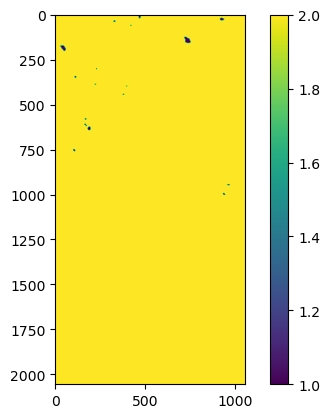

In [138]:
merged_water = merged_water[0]
merged_water[merged_water>0]= 2
merged_water[merged_water<= -9999]= 2 # For undefined values
merged_water[merged_water <= 0] = 1
plt.imshow(merged_water)
plt.colorbar()

In [139]:
# Create a cropping mask with the boundary of input image
image_file = os.path.join(test_path, 'images',image_name)
image_tile = rasterio.open(image_file)
mask_geometry = [shapely.geometry.box(*image_tile.bounds)]
mask_array = geometry_mask(mask_geometry, out_shape=merged_water.shape, transform = merged_transf, invert=True)

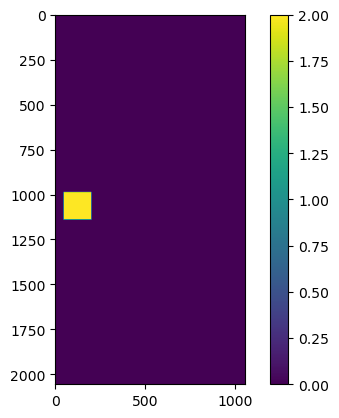

In [140]:
croped_water = merged_water*mask_array
plt.imshow(croped_water)
plt.colorbar()

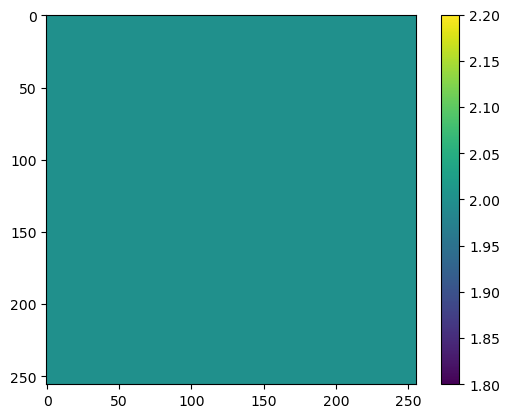

In [141]:
# Find the top-left, top-right, bottom-left, and bottom-right of the image corners
# Find indices where the value is 1
indices = np.where(croped_water >0)

top_left = (min(indices[0]), min(indices[1]))
bottom_right = (max(indices[0]), max(indices[1]))
extracted_water = croped_water[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
# resize
water_mask_img = skimage.transform.resize(extracted_water, image_tile.shape, mode='constant', order=1)
plt.imshow(water_mask_img)
plt.colorbar()

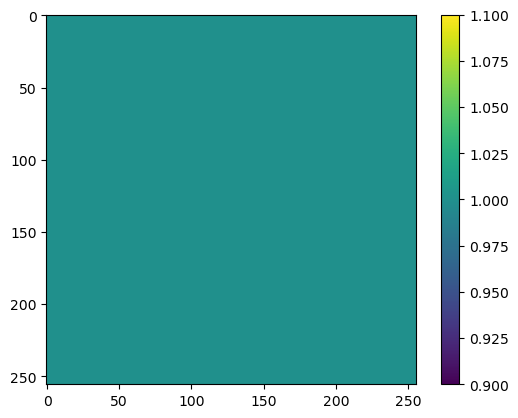

In [142]:
water_mask_img[water_mask_img<1.5]=0
water_mask_img[water_mask_img>0] = 1
plt.imshow(water_mask_img)
plt.colorbar()

In [143]:
keep_i = []
for predicted_i in range(len(preds[0]['labels'])):
    predicted_RTS = preds[0]['masks'][predicted_i][0].detach().numpy() # 0 is for channel
    outside_water = water_mask_img * predicted_RTS
    outside_water_fraction = outside_water.sum() / predicted_RTS.sum()
    if fraction_inslope >= threshold_onslope:
        keep_i.append(False)
    else:
        keep_i.append(True)

if len(keep_i)>0:
    boolean_mask = torch.tensor(keep_i)
    transf_box = output["boxes"][boolean_mask] 
    transf_labels = output["labels"][boolean_mask]
    transf_scores = output["scores"][boolean_mask]
    transf_mask = output["masks"][boolean_mask]
else:
    transf_box = output["boxes"]
    transf_labels = output["labels"]
    transf_scores = output["scores"]
    transf_mask = output["masks"]
return transf_box, transf_labels, transf_scores, transf_mask


NameError: name 'fraction_inslope' is not defined

In [326]:
len(preds[0]['labels'])

3

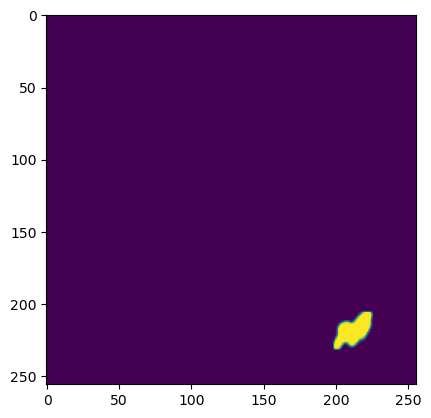

In [325]:
plt.imshow(preds[1]['masks'][0][0].detach().numpy())

Visualize

In [191]:
# Create an iterator from the DataLoader
data_iter = iter(test_dataloader)
n_batch = 38
data_iter = iter(test_dataloader)

search = '2010-2016_tile_15_41_5_6_5_3.tif'
found_flag = False

for i in range(n_batch):
    print("batch", i)
    batch_test = next(data_iter)
    img_org, targ_org = batch_test
    
    for instance in range(len(targ_org)):
        if targ_org[instance]['tile'] == search:
            print('found')
            found_flag = True
            break  # Break out of the inner loop

    if found_flag:
        break  # Break out of the outer loop
print('batch', i, instance)

batch 0
found
batch 0 3


In [192]:
img_org, targ_org = batch_test
preds = model.forward(img_org)
preds_org = model.forward(img_org)

Number of predicted RTS: 1 Number of labeled RTS: 1
Accuracy: 1.0, Precision: 0.62, Recall: 0.68, F1: 0.65, IoU: 0.48


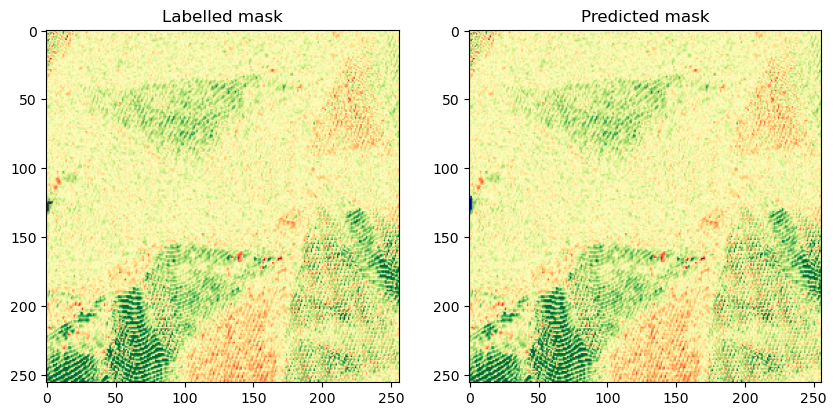

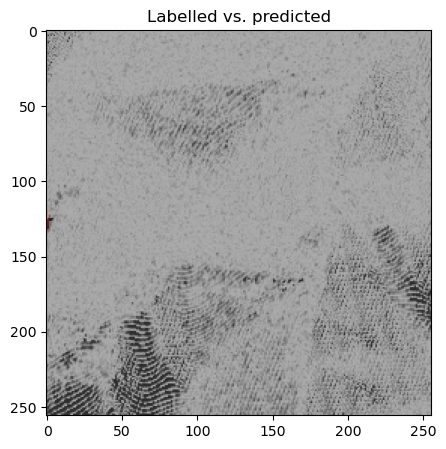

In [193]:
img_index = 3
viz_mask(img_org, targ_org, preds_org, img_index, viz_max = 3, viz_min = -3)

Number of predicted RTS: 1 Number of labeled RTS: 1
accuracy: 0.9988250732421875 precision: 0.8482905982905983 recall: 0.9851116625310173 f1: 0.9115958668197474 IoU: 0.8375527426160337


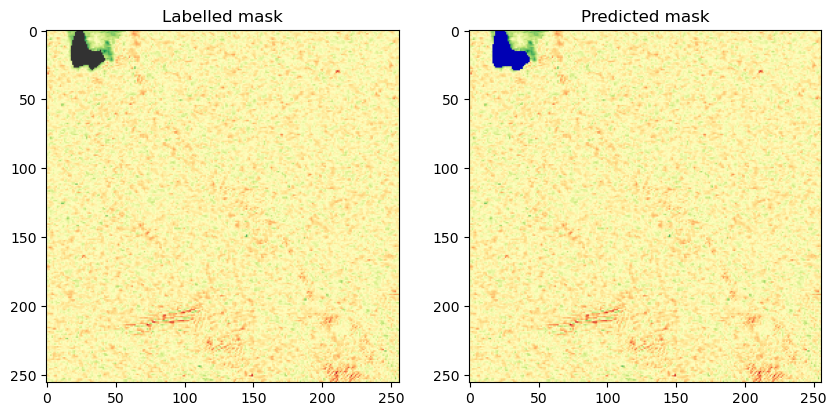

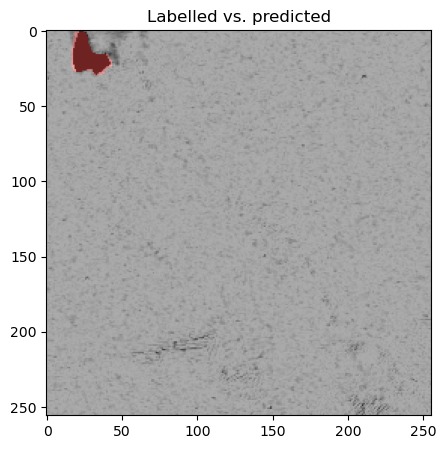

In [31]:
img_index = 3
viz_mask(img_org, targ_org, preds_org, img_index, viz_max = 3, viz_min = -3)

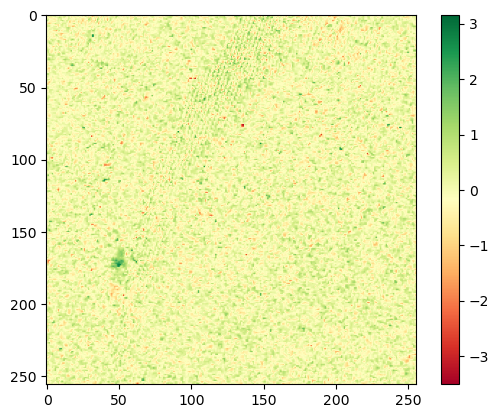

In [26]:
from matplotlib.colors import TwoSlopeNorm
img_index = 4
center_scaled = 0
viz_max = 3
viz_min = -3
img = img_org[img_index][0].numpy()
norm = TwoSlopeNorm(vmin=viz_min, vcenter=center_scaled, vmax=viz_max)

plt.imshow(img ,cmap='RdYlGn')
plt.colorbar()

Number of predicted RTS: 4 Number of labeled RTS: 1
accuracy: 0.9980926513671875 precision: 0.4131455399061033 recall: 1.0 f1: 0.584717607973422 IoU: 0.4131455399061033


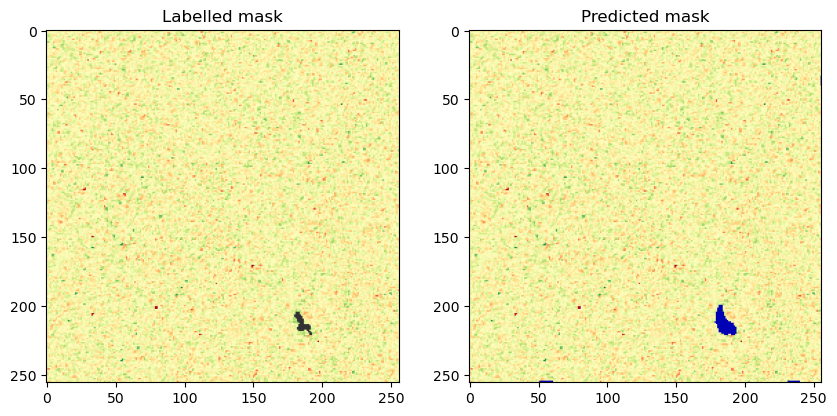

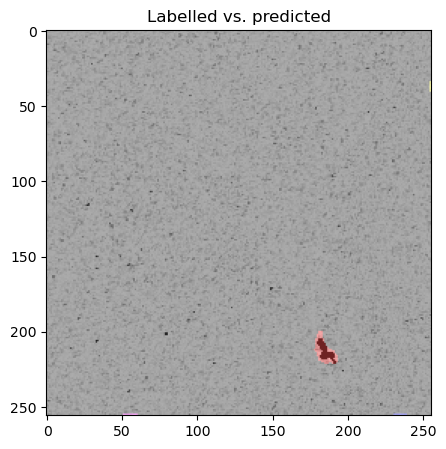

In [53]:
img_index = 2
viz_mask(img_org, targ_org, preds_org, img_index, viz_max = 3, viz_min = -3)

***

***
## Save model, continue training based on pretrained weights

In [ ]:
# Load the best checkpoint
checkpoint_path = 'checkpoint'
check_point_p = sorted(f for f in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path, f)))
check_point_f = torch.load(os.path.join(checkpoint_path, check_point_p[-1]))

In [ ]:
# Load weights of saved model into new model
model_new = Model(num_classes, pretrained_network) # num_classes = 2
model_new.load_state_dict(check_point_f["state_dict"])

### Continuing training

In [ ]:
wandb.finish()

In [ ]:
# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='RTS_smalldataset_retrain')

# add your batch size to the wandb config
wandb_logger.experiment.config["batch_size"] = config['batch_size']

In [ ]:
# Track learning rate and model checkpoints 

lr_monitor = LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoint',
    filename='maskrcnn_{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,  # Save the top 3 checkpoints
    verbose=True, # Whether callback will print information when a checkpoint is saved 
    monitor="validation_accuracy",  # validation loss: 'val_loss', validation accuracy: "val_accuracy"
    mode='max',  # 'min' for val_loss, max for val_accuracy
    every_n_epochs=1,  # Save a checkpoint every x epochs
    every_n_train_steps=None,  # Save a checkpoint every N training steps (set to None to disable)
    train_time_interval=None  # Save a checkpoint after a certain time interval (set to None to disable)
)


callbacks_trainer =[lr_monitor, checkpoint_callback]

In [ ]:
if gpu:
    # Training with GPU Accelerator using 2 GPUs
    trainer = pl.Trainer(devices=gpu_device, accelerator="gpu", max_epochs=config["epochs"], deterministic=False,callbacks=callbacks_trainer,logger=wandb_logger )
else:
# CPU accelerator
    trainer = pl.Trainer(accelerator="cpu", max_epochs=config["epochs"], deterministic=True,callbacks=callbacks_trainer,logger=wandb_logger )

In [ ]:
# Continue training
trainer.fit(model_new, train_dataloader, val_dataloader)

In [ ]:
wandb.finish()

***
### Visualizations

In [ ]:
vize_sample(third_batch, 3, model_viz = None, threshold_mask = 0.5,predictions = preds)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=config['batch_size'], shuffle=False, num_workers=0,
    collate_fn=lambda x: list(zip(*x)))

In [ ]:
# Create an iterator from the DataLoader
data_iter = iter(test_dataloader)

In [ ]:
first_batch = next(data_iter)

In [ ]:
second_batch = next(data_iter)

In [ ]:
third_batch = next(data_iter)

In [ ]:
preds = model.forward(img_org)

In [ ]:
from src.visualizations import viz_bounding_box

In [ ]:
viz_bounding_box(third_batch, sample_index=6, threshold_mask=0.5, preds = preds)

***
Hyperparameter sweep

In [ ]:
# TODO: Finish once overfitting is done

In [ ]:
wandb.finish()
wandb.login()

In [ ]:
# Track learning rate and model checkpoints 

lr_monitor = LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoint',
    filename='maskrcnn_{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=3,  # Save the top 3 checkpoints
    verbose=True, # Whether callback will print information when a checkpoint is saved 
    monitor="validation_accuracy",  # validation loss: 'val_loss', validation accuracy: "val_accuracy"
    mode='max',  # 'min' for val_loss, max for val_accuracy
    every_n_epochs=1,  # Save a checkpoint every x epochs
    every_n_train_steps=None,  # Save a checkpoint every N training steps (set to None to disable)
    train_time_interval=None  # Save a checkpoint after a certain time interval (set to None to disable)
)


callbacks_trainer =[lr_monitor, checkpoint_callback]

In [ ]:
# First try
# other possible config: dropout
# TODO: check early_terminate
sweep_config = {
    "method": "random", # grid, random, bayes
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "val_acc"}, #minimize loss, maximize val_acc
    "parameters": {
        "optimizer": {"values": ['sgd']}, # TODO: once adam is implemented,"optimizer": {"values": ['adam', 'sgd']},
        "batch_size": {"values": [1, 2]}, #"batch_size": {'distribution': 'q_log_uniform_values', "values": [1, 10]},
        "epochs": {"values": [1, 3]},
        "lr": {'distribution': 'uniform', "max": 0.1, "min": 0.0001},
    },
}

sweep_id = wandb.sweep(sweep_config, project="RTS_sweep")

# Define a function to train your model
def sweep_iteration():
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger = WandbLogger()
    
    # Create and train your model using the specified hyperparameters
    model_sweep = Model(num_classes, lr=wandb.config.lr)


    train_dataloader_sweep = torch.utils.data.DataLoader(
    train_set, batch_size=wandb.config.batch_size, shuffle=True, num_workers=worker_processes,
    collate_fn=lambda x: tuple(zip(*x)))

    val_dataloader_sweep = torch.utils.data.DataLoader(
    val_set, batch_size=wandb.config.batch_size, shuffle=False, num_workers=worker_processes,
    collate_fn=lambda x: tuple(zip(*x)))

    trainer = pl.Trainer(accelerator="cpu", max_epochs=wandb.config.epochs, deterministic=False,callbacks=callbacks_trainer, logger=wandb_logger)
    
    # Train the model using your training and validation data
    trainer.fit(model_sweep, train_dataloader_sweep, val_dataloader_sweep)
    
    # Log metrics
    # Retrieve and log the "loss_IoU similarity" from the final training step
    last_training_step_output = trainer.callback_metrics
    loss_IoU similarity = last_training_step_output["loss_IoU similarity"]

    wandb.log({"loss_IoU similarity": loss_IoU similarity})

# Initialize the sweep and start it
if sweep_config['method'] == 'random':
    wandb.agent(sweep_id, function=sweep_iteration, count=3) # Count = number of sweeps if random
else:
    wandb.agent(sweep_id, function=sweep_iteration) # gridsearch goes through all parameters

In [ ]:
# TODO Access data
loss_IoU similarity_values = logged_metrics["loss_IoU similarity"]

# Sample dictionary of hyperparameters and their corresponding validation losses
hyperparameters_and_metrics = {
    "loss": loss_IoU similarity_values,
    "batch_size": [32, 64, 128]
}

# Assume you want to minimize validation loss. TODO: change
best_hyperparameters = min(hyperparameters_and_metrics, key=hyperparameters_and_metrics.get)

# Extract the best configuration
best_learning_rate = best_hyperparameters["learning_rate"]
best_batch_size = best_hyperparameters["batch_size"]

***
## Generate file directories

In [ ]:
# Split between train and test for mask and image in raw data
name = "Sophia"
# Move fraction of train data to test folder
source_directory = f"data/{name}/data_train/data_original/masks"
source_directory2 = f"data/{name}/data_train/data_original/images"

destination_directory = f"data/{name}/data_test/masks"
destination_directory2 = f"data/{name}/data_test/images"
fraction_to_move = 0.2

split_train_test_mask(source_directory, destination_directory, source_directory2, destination_directory2, fraction_to_move)

In [ ]:
# move all data to clean data before cleaning
# Data path to image and masks
data_path_raw = f'data/{name}/data_raw/data_original/data_train'
test_path_raw = f'data/{name}/data_raw/data_original/data_test'
data_path = f'data/{name}/data_clean/data_original/data_train'
test_path = f'data/{name}/data_clean/data_original/data_test'

move_images(data_path_raw, data_path, all_ = True)
move_images(test_path_raw, test_path, all_ = True)

In [ ]:
# Clean data
dataset = DEMDataset(data_path_raw, n_channel = 1, channel_list = ["images"])
test_set = DEMDataset(test_path_raw, n_channel = 1, channel_list = ["images"])
original_data = DEMDataset(data_path_raw, n_channel = 1, channel_list = ["images"])
original_test = DEMDataset(test_path_raw, n_channel = 1, channel_list = ["images"])
# Clean data and generate clean file directory 
dataset, test_set = utils.clean_raw_data(dataset, test_set, original_data, original_test, test_path, data_path)

In [204]:
# Add slope, aspect data and split into train/ test
# Move / split slope and aspect data according to mask and image directories
# List all names in cleaned directory
tile_train = [item for item in os.listdir(os.path.join(data_path, "masks"))
                           if item.endswith(".tif")]
check_train = [item for item in os.listdir(os.path.join(data_path, "images"))
                           if item.endswith(".tif")]
tile_test = [item for item in os.listdir(os.path.join(test_path, "masks"))
                           if item.endswith(".tif")]
check_test = [item for item in os.listdir(os.path.join(test_path, "images"))
                           if item.endswith(".tif")]
if (check_train != tile_train) | (check_test != tile_test):
    print("Warning, data has wrongly been added to the clean directory. Mask and image tiles do not correspond. Repeat data splitting and cleaning part")

# Slope train
slope_path_raw = f"data/{name}/data_raw/slope"
slope_path_clean = f"data/{name}/data_clean/data_train/slope"
move_images(slope_path_raw, slope_path_clean, all_ = False, to_move = tile_train)

# slope test
slope_test_clean = f"data/{name}/data_clean/data_test/slope"
move_images(slope_path_raw, slope_test_clean, all_ = False, to_move = tile_test)

# aspect train
aspect_path_raw = f"data/{name}/data_raw/aspect"
aspect_path_clean = f"data/{name}/data_clean/data_train/aspect"
move_images(aspect_path_raw, aspect_path_clean, all_ = False, to_move = tile_train)

# aspect test
aspect_test_clean = f"data/{name}/data_clean/data_test/aspect"
move_images(aspect_path_raw, aspect_test_clean, all_ = False, to_move = tile_test)

### Data augmentation

In [17]:
# Get train set from above to ensure that it uses same dataset as in training
'''
# Split the dataset in train and val set
random.seed(seed_value)
percentage = 0.8
train_set, val_set = split_dataset_by_percentage(dataset, percentage)
print(len(train_set), len(val_set), len(dataset))
'''

'\n# Split the dataset in train and val set\nrandom.seed(seed_value)\npercentage = 0.8\ntrain_set, val_set = split_dataset_by_percentage(dataset, percentage)\nprint(len(train_set), len(val_set), len(dataset))\n'

In [13]:
# Generate transformed data. For each transformation, a new dataset is extracted from train_set (50%)

random.seed(seed_value)
torch.manual_seed(seed_value)

path_original = f"data/{name}/data_clean/data_train/data_original"
channel_t = ["images", "masks", "aspect", "slope"]
percentage = 0.5

# Horizontal flip transformation-----------------------------------------
tobe_transformed, _ = split_dataset_by_percentage(train_set, percentage)
for channel in channel_t:
    # Transform each image/ channel
    for _, targ in tobe_transformed:
        # Path to original image
        path_tobe_transf = os.path.join(path_original, channel, targ['tile'])

        # Path to file directory save
        path_transformation = f"data/{name}/data_clean/data_train/data_transformed/h_flipping"
        path_save = os.path.join(path_transformation, channel, targ['tile'])

        # Horizontal flip & save image
        Image.open(path_tobe_transf).transpose(Image.FLIP_LEFT_RIGHT).save(path_save, format="TIFF")
        
# Vertical flip transformation-----------------------------------------
tobe_transformed, _ = split_dataset_by_percentage(train_set, percentage)
for channel in channel_t:
    # Transform each image/ channel
    for _, targ in tobe_transformed:
        # Path to original image
        path_tobe_transf = os.path.join(path_original, channel, targ['tile'])

        # Path to file directory save
        path_transformation = f"data/{name}/data_clean/data_train/data_transformed/v_flipping"
        path_save = os.path.join(path_transformation, channel, targ['tile'])

        # Vertical flip & save image
        Image.open(path_tobe_transf).transpose(Image.FLIP_TOP_BOTTOM).save(path_save, format="TIFF")

        
# Zoom in by 1.25
tobe_transformed, _ = split_dataset_by_percentage(train_set, percentage)
for channel in channel_t:
    round = 0
    # Transform each image/ channel
    for _, targ in tobe_transformed:

        # Path to original image
        path_tobe_transf = os.path.join(path_original, channel, targ['tile'])

        # Path to file directory save
        path_transformation = f"data/{name}/data_clean/data_train/data_transformed/zoom"
        path_save = os.path.join(path_transformation, channel, targ['tile'])

        # zoom & save image
        zm = clipped_zoom(np.array(Image.open(path_tobe_transf)), 1.25, channel)
        zoomed_img = Image.fromarray(zm)
        zoomed_img.save(path_save, format="TIFF")

# Zoom out by 0.75
tobe_transformed, _ = split_dataset_by_percentage(train_set, percentage)
for channel in channel_t:
    round = 0
    # Transform each image/ channel
    for _, targ in tobe_transformed:
        '''
        if round == 10:
            break
        round+=1'''
        # Path to original image
        path_tobe_transf = os.path.join(path_original, channel, targ['tile'])

        # Path to file directory save
        path_transformation = f"data/{name}/data_clean/data_train/data_transformed/zoom_out"
        path_save = os.path.join(path_transformation, channel, targ['tile'])

        # zoom & save image
        zm = clipped_zoom(np.array(Image.open(path_tobe_transf),dtype = float), 0.75, channel)
        zoomed_img = Image.fromarray(zm)
        zoomed_img.save(path_save, format="TIFF")


In [14]:
print("done")

done


In [15]:
# Change image names so that it can be differentiated to original image 
channel_t = ["images", "masks", "aspect", "slope"]
transformation =  ["h_flipping", "v_flipping", "zoom", "zoom_out"]
path_directory = "data/Sophia/data_clean/data_train/data_transformed"
for transformation_ in transformation:
    for channel in channel_t:
        path_d = os.path.join(path_directory, transformation_, channel)
        file_list = os.listdir(path_d)
        for filename in file_list:
            tilename, img_form = os.path.splitext(filename)
            if transformation_ == "h_flipping":
                addon = '_hflip'
            elif transformation_ == "v_flipping":
                addon = '_vflip'
            elif transformation_ == "zoom":
                addon = '_zoom'
            elif transformation_ == "zoom_out":
                addon = '_zoomout'
            else:
                break
            new_filename = f'{tilename}{addon}{img_form}'
            old_path = os.path.join(path_d, filename)
            new_path = os.path.join(path_d, new_filename)
            os.rename(old_path, new_path)

In [65]:
# Clean unvalid data
# Only zoom in can generate unvalid data (No longer contains RTS) -> Clean zoom data

data_root = f'data/{name}/data_clean/data_train/data_original_plus_transformed' #data_transformed/zoom'

# Clean data
toclean_zoom = DEMDataset(data_root, n_channel = 1, channel_list = ["images"])
original_zoom = DEMDataset(data_root, n_channel = 1, channel_list = ["images"])


In [ ]:
clean_zoomed_data(toclean_zoom, original_zoom, data_root)

In [95]:
def clean_zoomed_data(dataset, original_data, data_path):
    '''
    Delete dataset in data_clean folder that are invlid by using delete property generated in __getitem__ from file dictionary
    Invalid data: images that are empty (full of 0 or NaN) or corresponding mask are empty
    
    Input:
        dataset, test_set: DEM dataset generated from raw data, will be cleaned in this function through implementation in  __getitem__ 
        original_data, original_test: DEM dataset generated from raw data, uncleaned
        data_path: Path of tobe cleaned directory
    
    '''
    # Delete invalid entries from DEMDataset: __getitem__ deletes invalid entries == a one time iteration 
    for file in dataset:
        pass
    
    # Calculate intersection between original data and cleaned data 
    intersection_set = set(original_data.filename_list).intersection(dataset.filename_list)
    
    # Find the entries that are not in the intersection
    not_in_intersection = [entry for entry in original_data.filename_list + dataset.filename_list if entry not in intersection_set]
    
    # delete file form data_clean folder which are not in the intersection = data deleted in for loop above
    for file in not_in_intersection:
        delete_img = os.path.join(data_path, "images", file)
        if os.path.exists(delete_img):
            # Delete the file
            os.remove(delete_img)
            print(f"{file} image deleted successfully.")
        else:
            print(f"{file} image not found. No deletion performed.")
            
        delete_mask = os.path.join(data_path, "masks", file)
        if os.path.exists(delete_mask):
            os.remove(delete_mask)
            print(f"{file} mask deleted successfully.")
        else:
            print(f"{file} mask not found. No deletion performed.")
            
        delete_aspect = os.path.join(data_path, "aspect", file)
        if os.path.exists(delete_aspect):
            os.remove(delete_aspect)
            print(f"{file} aspect deleted successfully.")
        else:
            print(f"{file} aspect not found. No deletion performed.")
            
        delete_slope = os.path.join(data_path, "slope", file)
        if os.path.exists(delete_slope):
            os.remove(delete_slope)
            print(f"{file} slope deleted successfully.")
        else:
            print(f"{file} slope not found. No deletion performed.")

In [35]:
# Copy data over from original
root_path = 'data/Sophia/data_clean/data_train/data_original'
target_path = 'data/Sophia/data_clean/data_train/data_original_plus_transformed'
channel_ = ["images", "masks", "aspect", "slope"]
for channel in channel_:
    path_directory = os.path.join(root_path, channel)
    for file_name in  os.listdir(path_directory):
        path_origin = os.path.join(root_path, channel,file_name)
        path_target = os.path.join(target_path, channel,file_name)
        shutil.copy(path_origin, path_target)

In [40]:
# Copy data over from transformed
root_path = 'data/Sophia/data_clean/data_train/data_transformed'
target_path = 'data/Sophia/data_clean/data_train/data_original_plus_transformed'
transformation = ["h_flipping", "v_flipping", "zoom", "zoom_out"]
channel_ = ["images", "masks", "aspect", "slope"]
for transformation_ in transformation:
    for channel in channel_:
        path_directory = os.path.join(root_path, transformation_, channel)
        tot_filename = [item for item in os.listdir(path_directory)
                           if item.endswith(".tif")]
        for file_name in tot_filename:
            path_origin = os.path.join(root_path, transformation_, channel,file_name)
            path_target = os.path.join(target_path, channel,file_name)
            shutil.copy(path_origin, path_target)

# Clean data
channel_t = ["images", "masks", "aspect", "slope"]
transformation = ["h_flipping", "v_flipping", "zoom", "zoom_out"]
path_delete = "data/Sophia/data_clean/data_train/data_transformed"
for transformation_ in transformation:
    for channel in channel_t:
        path_d = os.path.join(path_delete, transformation_, channel)
        file_list = os.listdir(path_d)

        # Iterate over the files and delete each one
        for file_name in file_list:
            file_path = os.path.join(path_d, file_name)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    #print(file_path)
                    
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")

    

In [ ]:
# move data
import shutil
origin = 
target = 'data/Sophia/data_clean/data_train/data_original_plus_transformed'
shutil.copy(origin, target)

## Circular encoding of aspect data

In [769]:
root_pt_list = [f'data/{name}/data_clean/data_train/data_original', f'data/{name}/data_clean/data_train/data_original_plus_transformed', 
                f'data/{name}/data_clean/data_train/data_transformed/h_flipping', f'data/{name}/data_clean/data_train/data_transformed/v_flipping', 
               f'data/{name}/data_clean/data_train/data_transformed/zoom', f'data/{name}/data_clean/data_train/data_transformed/zoom_out',
               f'data/{name}/data_clean/data_test']

In [772]:
for root_pt in root_pt_list:
    tile_name = [item for item in os.listdir(os.path.join(root_pt, "aspect"))
                               if item.endswith(".tif")]
    round = 0
    for tile in tile_name:
        '''
        if round== 5:
            break
        round+=1
        '''
        # path to aspect image
        path_tobe_transf = os.path.join(root_pt, "aspect",tile)
        # Path to file directory save
        path_x_aspect = os.path.join(root_pt, 'x_aspect', tile)
        path_y_aspect = os.path.join(root_pt, 'y_aspect', tile)

        # Get data
        matrix_aspect = np.array(Image.open(path_tobe_transf))
        # Smooth image to get overall large pattern
        smoothed_matrix = gaussian_filter(matrix_aspect, sigma=15)
        # Circular encoding
        x_aspect = np.cos(smoothed_matrix)
        y_aspect = np.sin(smoothed_matrix)

        # save image
        Image.fromarray(x_aspect).save(path_x_aspect, format="TIFF")
        Image.fromarray(y_aspect).save(path_y_aspect, format="TIFF")

## Create directory only filled with 2021 data if it is also in 2016

In [ ]:
import shutil
channel_list = ['images', 'masks', 'slope']
dir1 = "data/Sophia/data_clean/data_test"
dir2 = "data/Sophia/data_clean/2010_2021"
dir3 = "data/Sophia/data_clean/2021_also_in_2016_train"

In [ ]:
# Copy file from dir2 to dir3 if name is in dir1
for channel in channel_list:
    for filename in os.listdir(os.path.join(dir1, channel)):
        filename10_21 = '2010-2021' + filename[9:]
        file_path_copy = os.path.join(dir2, channel, filename10_21)
        filename11_21 = '2011-2021' + filename[9:]
        file_path_copy11 = os.path.join(dir2, channel, filename11_21)

        if os.path.exists(file_path_copy):
            shutil.copy(file_path_copy, os.path.join(dir3, channel))
        elif os.path.exists(file_path_copy11):
            shutil.copy(file_path_copy11, os.path.join(dir3, channel))
        #else:
            #print(f"File '{filename[9:]}' not found in {dir2}")

***
# minmax normalize data 
### Get global min, max for min-max scaling (Currently only of clean data)

In [793]:
channel_list = ['aspect','images', 'masks', 'slope', 'x_aspect', 'y_aspect'] # , 'images', 'masks', 'slope', 'x_aspect', 'y_aspect'
aspect_min = np.nan
aspect_max = np.nan
images_min = np.nan
images_max = np.nan
masks_min = np.nan
masks_max = np.nan
slope_min = np.nan
slope_max = np.nan
x_aspect_min = np.nan
x_aspect_max = np.nan
y_aspect_min = np.nan
y_aspect_max = np.nan


root_pt_list = ['data/Sophia/data_clean/data_train/data_original', 'data/Sophia/data_clean/data_test']


for channel in channel_list:
    for root in root_pt_list:
        tile_name = [item for item in os.listdir(os.path.join(root, channel))
                               if item.endswith(".tif")]
        for i, tile in enumerate(tile_name):
            tile_path =os.path.join(root, channel, tile)
            img = np.array(Image.open(tile_path))
            min_local = np.min(img)
            max_local = np.max(img)
            if i ==0: # first image cannot overwrite np.nan
                if channel == 'aspect':
                    aspect_min = min_local
                    aspect_max = max_local
                elif channel == 'images':
                    images_min = min_local
                    images_max = max_local
                elif channel == 'masks':
                    masks_min = min_local
                    masks_max = max_local
                elif channel == 'slope':
                    slope_min = min_local
                    slope_max = max_local
                elif channel == 'x_aspect':
                    x_aspect_min = min_local
                    x_aspect_max = max_local
                elif channel == 'y_aspect':
                    y_aspect_min = min_local
                    y_aspect_max = max_local
                

            else: # one has to check if local max/ min is global max/min
                if channel == 'aspect':
                    if min_local < aspect_min:
                        aspect_min = min_local
                    if max_local > aspect_max:
                        aspect_max = max_local
                elif channel == 'images':
                    if min_local < images_min:
                        images_min = min_local
                    if max_local > images_max:
                        images_max = max_local
                elif channel == 'masks':
                    if min_local < masks_min:
                        masks_min = min_local
                    if max_local > masks_max:
                        masks_max = max_local
                elif channel == 'slope':
                    if min_local < slope_min:
                        slope_min = min_local
                    if max_local > slope_max:
                        slope_max = max_local
                elif channel == 'x_aspect':
                    if min_local < x_aspect_min:
                        x_aspect_min = min_local
                    if max_local > x_aspect_max:
                        x_aspect_max = max_local
                elif channel == 'y_aspect':
                    if min_local < y_aspect_min:
                        y_aspect_min = min_local
                    if max_local > y_aspect_max:
                        y_aspect_max = max_local

In [805]:
data  = {'aspect_min': [aspect_min], 'aspect_max': [aspect_max], 'images_min': [images_min], 'images_max': [images_max], 'masks_min':[masks_min], 'masks_max':[masks_max],
         'slope_min': [slope_min], 'slope_max': [slope_max], 'x_aspect_min':[x_aspect_min],
         'x_aspect_max': [x_aspect_max],'y_aspect_min': [y_aspect_min], 'y_aspect_max': [y_aspect_max], 'x_aspect_max': [x_aspect_max], 'y_aspect_min': [y_aspect_min],'y_aspect_max': [y_aspect_max]}

In [808]:
min_max = pd.DataFrame(data)

In [809]:
min_max.to_csv('min_max.csv', index=False)

### Min max normalize

In [842]:
root_pt_list = ['data/Sophia/data_clean/data_train/data_original', 'data/Sophia/data_clean/data_train/data_original_plus_transformed',
           'data/Sophia/data_clean/data_test']
destination_pth = ['data/Sophia/data_clean/data_train/data_original_scaled', 'data/Sophia/data_clean/data_train/data_original_plus_transformed_scaled',
                  'data/Sophia/data_clean/data_test_scaled']
channel_list = ['images', 'masks', 'slope', 'x_aspect', 'y_aspect']

for root_i, root in enumerate(root_pt_list):
    for channel in channel_list:
        tile_name = [item for item in os.listdir(os.path.join(root, channel))
                               if item.endswith(".tif")]
        for i, tile in enumerate(tile_name):
            tile_path =os.path.join(root, channel, tile)
            img = np.array(Image.open(tile_path))
            if channel == 'images':
                images_min = min_max['images_min'][0]
                images_max = min_max['images_max'][0]
                img_transf = (img-images_min)/(images_max-images_min)

                path_save = os.path.join(destination_pth[root_i], channel, tile)
                Image.fromarray(img_transf).save(path_save, format="TIFF")

            elif channel == 'masks': # no mormalization needed, is label channel
                path_save = os.path.join(destination_pth[root_i], channel, tile)
                Image.fromarray(img).save(path_save, format="TIFF")

            elif channel == 'slope':
                slope_min = min_max['slope_min'][0]
                slope_max = min_max['slope_max'][0]
                img_transf = (img-slope_min)/(slope_max-slope_min)
                path_save = os.path.join(destination_pth[root_i], channel, tile)
                Image.fromarray(img_transf).save(path_save, format="TIFF")

            elif channel == 'x_aspect':
                x_aspect_min = min_max['x_aspect_min'][0]
                x_aspect_max = min_max['x_aspect_max'][0]
                img_transf = (img-x_aspect_min)/(x_aspect_max-x_aspect_min)
                path_save = os.path.join(destination_pth[root_i], channel, tile)
                Image.fromarray(img_transf).save(path_save, format="TIFF")
            elif channel == 'y_aspect':
                y_aspect_min = min_max['y_aspect_min'][0]
                y_aspect_max = min_max['y_aspect_max'][0]
                img_transf = (img-y_aspect_min)/(y_aspect_max-y_aspect_min)
                path_save = os.path.join(destination_pth[root_i], channel, tile)
                Image.fromarray(img_transf).save(path_save, format="TIFF")

### Get global mean, sd of normalized data

In [71]:
channel_list = ['images', 'slope', 'x_aspect', 'y_aspect']

img_data = []
slope_data = []
x_data = []
y_data = []

path_data = ['data/Sophia/data_clean/data_train/data_original']

for path_d in path_data:
    for channel in channel_list:
        tile_name = [item for item in os.listdir(os.path.join(path_d, channel))
                               if item.endswith(".tif")]
        for i, tile in enumerate(tile_name):
            matrix = np.array(Image.open(os.path.join(path_d, channel, tile)))            
            if channel == 'images':
                img_data.append(matrix)
            elif channel == 'slope':
                slope_data.append(matrix)
            elif channel == 'x_aspect':
                x_data.append(matrix)
            elif channel == 'y_aspect':
                y_data.append(matrix)
                                     

In [70]:
aa = [item for item in os.listdir(os.path.join(path_data[0], channel))
                               if item.endswith(".tif")]

FileNotFoundError: [Errno 2] No such file or directory: 'data/Sophia/data_clean/data_train/data_original_scaled/images'

In [72]:
img_tot = np.concatenate(img_data)
img_sd = np.nanstd(img_tot)
img_mean = np.nanmean(img_tot)

slope_tot = np.concatenate(slope_data)
slope_sd = np.nanstd(slope_tot)
slope_mean = np.nanmean(slope_tot)

x_tot = np.concatenate(x_data)
x_sd = np.nanstd(x_tot)
x_mean = np.nanmean(x_tot)

y_tot = np.concatenate(y_data)
y_sd = np.nanstd(y_tot)
y_mean = np.nanmean(y_tot)

In [73]:
import pandas as pd

# Example data
data = {
    'img_sd': [img_sd],
    'img_mean': [img_mean],
    'slope_sd': [slope_sd],
    'slope_mean': [slope_mean],
    'x_sd': [x_sd],
    'x_mean': [x_mean],
    'y_sd': [y_sd],
    'y_mean': [y_mean]
}

# Create a DataFrame
mean_sd = pd.DataFrame(data)
mean_sd.to_csv('mean_sd.csv', index=False)

## Create directory only filled with 2021 data if it is also in 2016

In [255]:
import shutil
channel_list = ['images', 'masks', 'slope']
dir1 = "data/Sophia/data_clean/data_test"
dir2 = "data/Sophia/data_clean/2010_2021"
dir3 = "data/Sophia/data_clean/2021_also_in_2016_train"

In [257]:
for channel in channel_list:
    for filename in os.listdir(os.path.join(dir1, channel)):
        filename10_21 = '2010-2021' + filename[9:]
        file_path_copy = os.path.join(dir2, channel, filename10_21)
        filename11_21 = '2011-2021' + filename[9:]
        file_path_copy11 = os.path.join(dir2, channel, filename11_21)

        if os.path.exists(file_path_copy):
            shutil.copy(file_path_copy, os.path.join(dir3, channel))
        elif os.path.exists(file_path_copy11):
            shutil.copy(file_path_copy11, os.path.join(dir3, channel))
        #else:
            #print(f"File '{filename[9:]}' not found in {dir2}")

***
# Find model path

In [164]:
# Recursive search to find model path
def go_deeper(getattr_, attribute_to_search, path, dict_previous = []):
    dictionary = dir(getattr_)
    
    if dict_previous == dictionary:
        path.append('_breakloop')
        return dictionary
    
    elif any(attribute_to_search in s for s in dictionary):
        found_attribute = [entry for entry in dictionary if attribute_to_search in entry]
        print(f'found: {found_attribute}')
        #print(getattr_)
        print(dictionary)
        
        
    if type(dictionary) == list:
        for entry in dictionary:
            attribute = str(entry)
            if attribute in path:
                continue
            elif not attribute.startswith('__') and not attribute.startswith('_') and attribute != 'H' and attribute != 'T' and attribute != 'mH' and attribute != 'mT':
                path.append(attribute)
                #print(attribute)
                path.append('...')
                go_deeper(getattr(getattr_, attribute), attribute_to_search, path, dictionary)
        path.append('_finished_directory')
                
    else:  
        path.append('_')
        #print('return')
        return dictionary
        

In [179]:
path = []
search_for = 'batch'
test = go_deeper(getattr(model, 'detector'), search_for, path)
test

found: ['batch_size_per_image']
['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'batch_size_per_image', 'positive_fraction']
found: ['_onnx_batch_images', 'batch_images']
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_

In [166]:
id_search = path.index('box_predictor')
id_search

2270

In [167]:
# Split list at '_finished_directory' and only keep those that where not finished
my_list = path[:id_search+1]

# Initialize a list to store sublists
result = []
sublist = []

# Iterate through the elements of the list
for item in my_list:
    if item == '_finished_directory':
        # If ':' is encountered, append the current sublist to the result list
        result.append(sublist)
        # Reset the sublist for the next group
        sublist = []
    else:
        # Add the item to the current sublist
        sublist.append(item)

# Append the last sublist if the list ends with an element other than ':'
if sublist:
    result.append(sublist)

In [168]:
finished = []
i_remove = []
i_loop_end = []
for i, element in enumerate(result):
    if len(element) <1: # empty: means that higher hiarchical loop is finished
        i_loop_end.append(i)
        i_remove.append(i)
    elif element[-1].endswith('...'): 
        if len(element)>=3:
            finished.append(element[-2]) # add finished directory
            result[i] = element[:-2]
        else:  # only entry is finished directory-> remove
            finished.append(element[0])
            i_remove.append(i)
    elif element[-1] == '_breakloop':
        i_remove.append(i)
                              

In [169]:
# Check how many hiarchies are closed
adjacent_indices = []

for i in range(len(i_loop_end) - 1):
    if i_loop_end[i + 1] - i_loop_end[i] == 1:
        adjacent_indices.append((i_loop_end[i], i_loop_end[i + 1]))

print("Adjacent indices:", adjacent_indices)

Adjacent indices: [(193, 194), (728, 729), (735, 736)]


In [170]:
last_closed_loop = adjacent_indices[-1][-1]
last_closed_loop

736

In [171]:
adapted_remove = list(np.array(i_remove) - last_closed_loop)
unclosed = result[last_closed_loop:]


In [172]:
filtered_list_ = [element for index, element in enumerate(unclosed) if index not in adapted_remove]

In [173]:
filtered_list_

[['roi_heads', '...'],
 ['box_coder', '...'],
 ['box_head', '...', 'fc6', '...'],
 ['box_predictor']]

In [732]:
print(model.detector.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


In [710]:
print(model.detector.rpn._post_nms_top_n)

{'training': 2000, 'testing': 1000}


In [565]:
print(model.detector.roi_heads.nms_thresh)

0.5


In [21]:
model.detector.roi_heads.detections_per_img

100

In [29]:
print(model.detector.roi_heads)

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (mask_head): MaskRCNNHeads(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(

In [11]:
# activate, deactivate batch norm 
def set_bn_eval(m):
    if isinstance(m, nn.modules.batchnorm._BatchNorm):
        m.eval()


def set_bn_train(m):
    if isinstance(m, nn.modules.batchnorm._BatchNorm):
        m.train()
        
model.apply(set_bn_eval)
isinstance(model.detector.backbone.body.layer1[0].bn1,  torchvision.ops.misc.FrozenBatchNorm2d)

In [254]:
import shutil
shutil.rmtree('data/Sophia/data_clean/2021_also_in_2016_train')

In [ ]:
default_drop_out